<a href="https://colab.research.google.com/github/jubabdag/Git-Flisol2019/blob/master/Imers%C3%A3o_DataScience_Dia3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UM DESAFIO HARVARD...
---

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
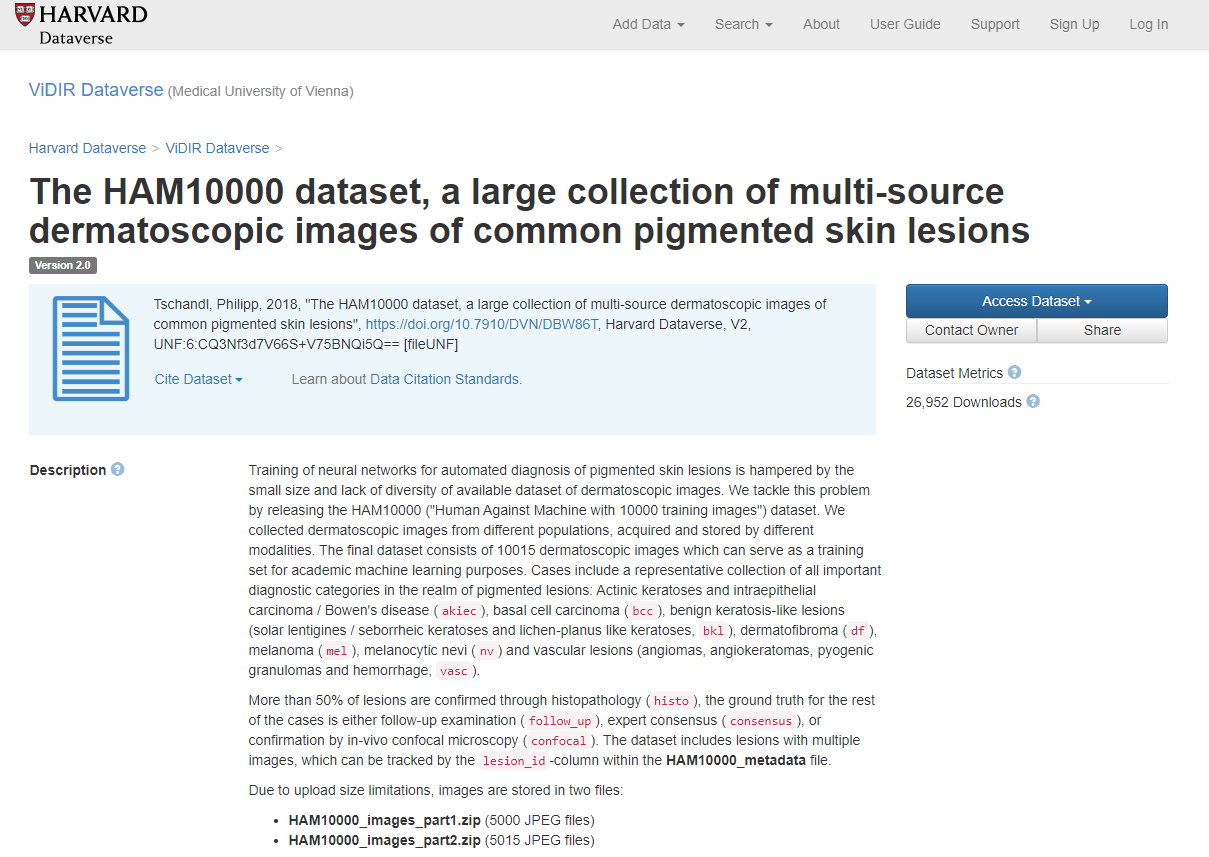

## ANÁLISE DE CÂNCER DE PELE POR FOTO

---

![tipos câncer](https://miiskin.com/wp-content/uploads/2019/08/types-of-skin-cancer-700x514.jpg)

O câncer de pele é o mais comum, e é diagnosticado principalmente visualmente, começando com uma triagem clínica inicial e seguido potencialmente por análise dermatoscópica, biópsia e exame histopatológico. A classificação automatizada de lesões cutâneas por meio de imagens é uma tarefa desafiadora devido à variabilidade refinada na aparência das lesões cutâneas.
<br><br>
Dataset utilizado: HAM10000 ("Human Against Machine with 10000 training images"). https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

<br>Consiste em 10015 imagens dermatoscópicas que são lançadas como um conjunto de treinamento para fins de aprendizado de máquina acadêmico e estão publicamente disponíveis através do arquivo ISIC. Este conjunto de dados de referência pode ser usado para aprendizado de máquina e para comparações com especialistas humanos.<br><br>

Possui 7 classes diferentes de câncer de pele, listadas abaixo:
1. Nevos melanocíticos
2. Melanoma
3. Lesões semelhantes a ceratose benigna
4. Carcinoma basocelular
5. Ceratoses actínicas
6. Lesões vasculares
7. Dermatofibroma

## AQUISIÇÃO DOS DADOS

---

5GB OMFG! Bem, temos 2 alternativas mas ambas necessitarão que você efetue o download dos 5GB. Na pior das hipóteses, nós vamos deixar o modelo preditivo ja treinado pra você baixar e executar predições, mas sabia que isso é um atalho sujo se você tiver poder computacional pra treina-lo.


1.   Baixe o dataset em: https://drive.google.com/drive/folders/1j7eq5hcfZZ6rh8VHEcs7bfzNMYo3tAtZ?usp=sharing
2.   Após baixar o dataset e extrai-lo, suba ele para o Google drive e conect-se com ele pelo Colab.
3.   Baixe o dataset, descompacte o arquivo .zip e prepare-se para trabalhar em sua máquina.





In [ ]:
# CONEXÃO GOOGLE DRIVE/COLAB
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls gdrive/MyDrive/ham10000

HAM10000_images_part_1	hmnist_28_28_L.csv    hmnist_8_8_RGB.csv
HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_metadata.csv	hmnist_8_8_L.csv


In [ ]:

# PIP INSTALL LIBS ESPECÍFICAS EM SEU TERMINAL
!pip install numpy==1.18.0
!pip install pandas==1.0.1
!pip install Pillow==7.0.0
!pip install plotly==4.7.1
!pip install streamlit==0.58.0
!pip install tensorflow==1.14.0
!pip install Keras==2.2.5

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import plotly.express as px


import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## ANÁLISE EXPLORATÓRIA DE DADOS

In [ ]:
base_skin_dir = os.path.join('..', '/content/gdrive/MyDrive/ham10000/')

# HAM10000_images_part1.zip e HAM10000_images_part2.zip em 1 dict

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Dicionário útil pra facilitar a vida do usuário final

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_data = pd.read_csv('/content/gdrive/MyDrive/ham10000/HAM10000_metadata.csv')
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data.sample(3)

lesion_id      image_id  ...          cell_type cell_type_idx
9725  HAM_0004376  ISIC_0024843  ...  Actinic keratoses             0
6059  HAM_0003024  ISIC_0024768  ...   Melanocytic nevi             4
4540  HAM_0001659  ISIC_0026564  ...   Melanocytic nevi             4

[3 rows x 10 columns]

In [ ]:
# load in all of the images
from skimage.io import imread
skin_data['image'] = skin_data['path'].map(imread)

In [ ]:
# see the image size distribution
skin_data['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [ ]:
# REMOVER DADOS FALTANTES INSERINDO MEDIANA NELES
skin_data.isna().sum()
skin_data['age'] = skin_data['age'].fillna(skin_data['age'].median())

## PRÉ PROCESSAMENTO DOS DADOS

In [ ]:
features = skin_data.drop(columns=['cell_type_idx'],axis=1)
label= skin_data['cell_type_idx']

In [ ]:
Xtrain, X_test, y_train, y_test = train_test_split(features, label, test_size=0.20,random_state=42)

In [ ]:
# AQUI SUA MÁQUINA GOOGLE MORRERÁ
x_train = np.asarray(Xtrain['image'].tolist())
x_test = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
no_of_classes = len(np.unique(y_train))

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0] 

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_valid = x_valid.reshape(x_valid.shape[0], *(75, 100, 3))

In [ ]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train[0]

## MODELO PREDITIVO
![](https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png)

## VISÃO COMPUTACIONAL

---

![](https://necromuralist.github.io/neural_networks/posts/image-to-vector/image2vector_kiank.png)

In [ ]:
model = Sequential() # = input
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(75,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3)) # esquecer 0.3 dos dados para não decorar
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4)) # esquecer 0.4 dos dados para não decorar
model.add(Dense(7,activation = 'softmax')) # softmax = prever probabilidade/output
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

batch_size = 32

checkpointer = ModelCheckpoint(filepath = 'model.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=30,
        validation_data=(x_valid, y_valid),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

In [ ]:
# tendo o modelo preditivo já salvo, pode começar daqui :)
# carregar nosso modelo
model.load_weights('model.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia no teste:', score[1])

## PREDIÇÕES

In [ ]:
plt.figure(1)  
   
 # Resumo da acurácia(histórico)
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # Resumo da loss(histórico)
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

![](https://www.kaggleusercontent.com/kf/34121000/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..nfhYeBW5DfTudv8o24hSYA.EaFfvSHXix7dY2LI5205t92q8vqjd1eioFgi8tyL1rb_Lv6Jbu0PV0tSZEDVxsSSNQbb-j6ZzMzfr_xmtOshOAmS0X8yUjhrp6F-M2tnu4U1mmXayCu1bgHXqeUIWqoonO_tC1AJHOIsl3WY5EGvm6OC9rEmUv3BZpWiMt_gy53Cly_wpsDT03AM_-CkMp9aGfCKrThROAq6w1N5Jdr3ETnNWEgOfNt3Dk_SeHtk6UMRSHymdKRx2R-UaZfdFicCaiDomdFxlbkZg-0eFTuHd6D-bvtIcgdnJ5_MkS-6TaAgueh1b2mU7PcYhtxmHFN5hHk7D9eUUjTlab2STtgFcUe3d3KYqx93kxLtLFMAXlrpbiF6iPi0IHjzHLeDlxIfEF92cGro4UZSzqa3PJJnxgoesffm1iBTAZy2-_lBw8BofCh_SlK0cprmXs2Nd18o-45eR08wL6XNU3Q42J3dvxARUYYVPnNFBUsRdrJ9PrZ5nctgjz6eF7gd4Ozh9xSVX2QEpA6rhuF924cPtozbnjU394xrVOXvuUSNIB6zCLcO_6ydV5cC01nofLNZYFYwYOO2Ekdkp9Objl0S_zyp0QvVsLMaVpouHpjVhepADaGl3vTQNO3xkjTeDoQ4s0YinrBjRZhV4twV2GFIfFVRiKkPBXWWrH8KwC2gGCZrxN4.kcKyv03BGQH4JvqTDlmuSg/__results___files/__results___34_0.png)

## DEPLOY!

---

Com modelo preditivo treinado gratuitamente pela Google, agora podemos ir até nossa máquina local e utilizar IDE´S como Spyder ou simplesmente editores de texto para criarmos a pasta de nosso projeto final e enviar ao github. De lá conseguiremos enviar ao heroku nosso deploy Web. Para agilizar todo o processo, explicaremos cada passo e depois daremos um fork no repositório qoda já publicado para o seu github



1.   Acesse github.com
2.   Dê "FORK" em https://github.com/qodatecnologia/Skin-cancer-Analyzer
3.   Acesse heroku.com e conecte seu projeto com o seu link de repositório!



In [ ]:
# APP PRONTO

import streamlit as st
import numpy as np
import pandas as pd
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras import backend as K
import os
import time
import io
from PIL import Image
import plotly.express as px

MODELSPATH = './models/'
DATAPATH = './data/'


def render_header():
    st.write("""
        <p align="center"> 
            <H1> Doctor Skin
        </p>
    """, unsafe_allow_html=True)


@st.cache
def load_mekd():
    img = Image.open(DATAPATH + '/ISIC_0024312.jpg')
    return img


@st.cache
def data_gen(x):
    img = np.asarray(Image.open(x).resize((100, 75)))
    x_test = np.asarray(img.tolist())
    x_test_mean = np.mean(x_test)
    x_test_std = np.std(x_test)
    x_test = (x_test - x_test_mean) / x_test_std
    x_validate = x_test.reshape(1, 75, 100, 3)

    return x_validate


@st.cache
def data_gen_(img):
    img = img.reshape(100, 75)
    x_test = np.asarray(img.tolist())
    x_test_mean = np.mean(x_test)
    x_test_std = np.std(x_test)
    x_test = (x_test - x_test_mean) / x_test_std
    x_validate = x_test.reshape(1, 75, 100, 3)

    return x_validate

# carregamos nosso modelo preditivo ja treinado
def load_models():

    model = load_model(MODELSPATH + 'model.h5')
    return model

# realizamos as prediçoes
@st.cache
def predict(x_test, model):
    Y_pred = model.predict(x_test)
    ynew = model.predict_proba(x_test)
    K.clear_session()
    ynew = np.round(ynew, 2)
    ynew = ynew*100
    y_new = ynew[0].tolist()
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    K.clear_session()
    return y_new, Y_pred_classes

# Mostramos as predições
@st.cache
def display_prediction(y_new):
    """Display image and preditions from model"""

    result = pd.DataFrame({'Probability': y_new}, index=np.arange(7))
    result = result.reset_index()
    result.columns = ['Classes', 'Probability']
    lesion_type_dict = {2: 'Benign keratosis-like lesions', 4: 'Melanocytic nevi', 3: 'Dermatofibroma',
                        5: 'Melanoma', 6: 'Vascular lesions', 1: 'Basal cell carcinoma', 0: 'Actinic keratoses'}
    result["Classes"] = result["Classes"].map(lesion_type_dict)
    return result

# APLICAÇÃO PRINCIPAL
def main():
    st.sidebar.header('Doctor Skin')
    st.sidebar.subheader('Escolha uma página para continuar:')
    page = st.sidebar.selectbox("", ["Exemplos", "Faça Upload de sua imagem"])
    # USAR EXEMPLOS
    if page == "Exemplos":
        st.header("Exemplos para predição em câncer de pele")
        st.markdown("""
        **Predições**
        Você precisa selecionar dados de amostra
        """)

        mov_base = ['Sample Data I']
        movies_chosen = st.multiselect('Choose Sample Data', mov_base)

        if len(movies_chosen) > 1:
            st.error('Please select Sample Data')
        if len(movies_chosen) == 1:
            st.success("You have selected Sample Data")
        else:
            st.info('Please select Sample Data')

        if len(movies_chosen) == 1:
            if st.checkbox('Show Sample Data'):
                st.info("Showing Sample data---->>>")
                image = load_mekd()
                st.image(image, caption='Sample Data', use_column_width=True)
                st.subheader("Choose Training Algorithm!")
                if st.checkbox('Keras'):
                    model = load_models()
                    st.success("Hooray !! Keras Model Loaded!")
                    if st.checkbox('Show Prediction Probablity on Sample Data'):
                        x_test = data_gen(DATAPATH + '/ISIC_0024312.jpg')
                        y_new, Y_pred_classes = predict(x_test, model)
                        result = display_prediction(y_new)
                        st.write(result)
                        if st.checkbox('Display Probability Graph'):
                            fig = px.bar(result, x="Classes",
                                         y="Probability", color='Classes')
                            st.plotly_chart(fig, use_container_width=True)

    # UPLOAD
    if page == "Faça Upload de sua imagem":

        st.header("Faça Upload de sua imagem")

        file_path = st.file_uploader('Faça Upload de sua imagem', type=['png', 'jpg'])

        if file_path is not None:
            x_test = data_gen(file_path)
            image = Image.open(file_path)
            img_array = np.array(image)

            st.success('File Upload Success!!')
        else:
            st.info('Please upload Image file')

        if st.checkbox('Show Uploaded Image'):
            st.info("Showing Uploaded Image ---->>>")
            st.image(img_array, caption='Uploaded Image',
                     use_column_width=True)
            st.subheader("Choose Training Algorithm!")
            if st.checkbox('Keras'):
                model = load_models()
                st.success("Hooray !! Keras Model Loaded!")
                if st.checkbox('Show Prediction Probablity for Uploaded Image'):
                    y_new, Y_pred_classes = predict(x_test, model)
                    result = display_prediction(y_new)
                    st.write(result)
                    if st.checkbox('Display Probability Graph'):
                        fig = px.bar(result, x="Classes",
                                     y="Probability", color='Classes')
                        st.plotly_chart(fig, use_container_width=True)


if __name__ == "__main__":
    main()

In [ ]:
# CLONAR DO GITHUB PRA RODAR AQUI
!git clone https://github.com/qodatecnologia/Skin-cancer-Analyzer.git doctorskin
!cd doctorskin/

In [ ]:
!pip install -r doctorskin/requirements.txt

In [ ]:
!pip install pyngrok

In [ ]:
!streamlit run doctorskin/app.py &>/dev/null&

In [ ]:
from pyngrok import ngrok

# Setup a tunnel to the streamlit port 8501

public_url = ngrok.connect(port='8501')
public_url